# Titanic Survival - K-means clustering

We will use titanic dataset and unsupervised learning to explore whether the machine can figure out what drives survivability on it's own.

This will be done using **k-means clustering**, an unsupervised machine learning algorithm. The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K.The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.
(For more details- https://www.datascience.com/blog/k-means-clustering)

Get the `titanic3.csv` data (Source: [Link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

Following steps will be followed:

1. Analyzing the data using pandas.

    * Creating a column `child` that specifies whether the person is a child (age <= 10).
    * Creating a column `family_size` that specifies the size of the family of that person. 
    --------------------------------------------
2. Developing clusters for the dataset.

    * Imputing the `age` column with the **median**.
    * Droping all remaining NaN values.
    * Preprocessing the `sex` column using LabelEncoder.
    * Preprocessing the `child` column using LabelEncoder.
    * Scaling the data set to standardize the dataset using `sklearn.preprocessing.scale`
    * Running a KMeans cluster analysis. Pick an appropriate number of clusters.
    * Interpreting the results.
    -------------------------------------------------
3. Implementing a search for the best number of clusters using the silhouette score from `sklearn.metrics`.
    * Setting the parameters to 2,3,4,5,6 clusters.
    * Interpreting the best results.
    * Trying to find names for the clusters.

## Importing Packages and Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
raw = pd.read_csv("https://raw.githubusercontent.com/mschermann/msis2802winter2018homework/master/\
titanic3.csv")

In [6]:
tc = raw.copy()

## Description of the dataset

Each row is a passenger on the Titanic. The columns report attributes for the passengers:

| Column | Description | Relevant for this project|
|--------|-------------|--------|
|`survived`|1 = survived, 0 = died | **X**|
|`pclass`| 1 = first class, 2 = second class, 3 = third class |**X**|
|`name`| Name of the passenger| |
|`sex`| male or female|**X**|
|`age`| age in years|**X**|
|`sibsp`| The number of siblings or spouses that are also traveling on the Titanic| **X**|
|`parch`| The number of parents or childen that are also traveling on the Titanic| **X**|
|`ticket`|The ticket number| |
|`fare`| The ticket price | |
|`cabin`| The cabin number | |
|`embarked`| The starting city | |
|`boat`| The emergency boat number | |
|`body`| The identification number of the body | |
|`home.dest`| The destination of the passenger | |

### Keeping only relevant columns

In [7]:
tc=tc.drop(['name','ticket','fare','cabin','embarked','boat','body','home.dest'], axis=1);

In [8]:
tc.head()

,pclass,survived,sex,age,sibsp,parch
0,1.0,1.0,female,29.0000,0.0,0.0
1,1.0,1.0,male,0.9167,1.0,2.0
2,1.0,0.0,female,2.0000,1.0,2.0
3,1.0,0.0,male,30.0000,1.0,2.0
4,1.0,0.0,female,25.0000,1.0,2.0


## 1. Analyzing the data using pandas

#### Creating a column 'Child' that specifies whether the person is a child (age<=10)

Creating a column **child** that tells 1 if the person is child and 0 if not

In [9]:
tc['child']=[1 if x<=10 else 0 for x in tc['age']]
tc.head(3)

,pclass,survived,sex,age,sibsp,parch,child
0,1.0,1.0,female,29.0000,0.0,0.0,0
1,1.0,1.0,male,0.9167,1.0,2.0,1
2,1.0,0.0,female,2.0000,1.0,2.0,1


#### Creating a column `family_size` that specifies the size of the family of that person 

There are two relevant columns for this step - 
* sibps - The number of siblings or spouses that are also traveling on the Titanic
* parch - The number of parents or childen that are also traveling on the Titanic	
This combined will tell the number of people in the family excluding the person, Thus we need to add 1 in this.

In [10]:
tc['family_size']=tc['sibsp']+tc['parch']+1
tc.head(3)

,pclass,survived,sex,age,sibsp,parch,child,family_size
0,1.0,1.0,female,29.0000,0.0,0.0,0,1.0
1,1.0,1.0,male,0.9167,1.0,2.0,1,4.0
2,1.0,0.0,female,2.0000,1.0,2.0,1,4.0


## 2. Developing clusters for the dataset

#### Imputing the age column with the median

In [11]:
tc['age'].median()

28.0

To impute we will fill all nan values in the age column by median of the age

In [12]:
tc['age']=tc['age'].fillna(tc['age'].median())

#### Droping all remaining NaN values

In [13]:
tc=tc.dropna()

#### Preprocessing the sex column using LabelEncoder

In [14]:
le = pp.LabelEncoder()
tc['sex'].unique()
tc.sex = le.fit_transform(tc['sex'].astype(str))

array(['female', 'male'], dtype=object)

#### Preprocessing the child column using LabelEncoder

In [15]:
tc['child'].unique()
tc.child = le.fit_transform(tc['child'].astype(str))

array([0, 1], dtype=int64)

#### Scaling the data set to standardize the dataset using sklearn.preprocessing.scale

Dropping survived column from the feature list- X.

In [16]:
X=tc.drop(['survived'], axis=1)

Scaling the feature data using sklearn.preprocessing.scale

In [17]:
X = pd.DataFrame(pp.scale(X, axis=1))

In [18]:
y = le.fit_transform(tc['survived'].astype(str))

#### Running a KMeans cluster analysis. Pick an appropriate number of clusters

Using the **Elbow method** to find the optimal number of clusters

This method says that We need to stop at the number of clusters from where the rate of drop in WCSS is very less.

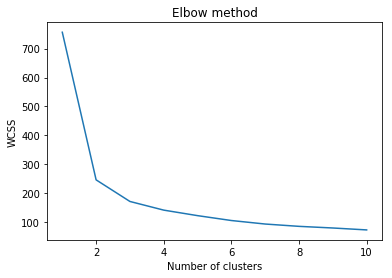

In [19]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
   kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
   kmeans.fit(X);
   wcss.append(kmeans.inertia_);


plt.plot(range(1,11), wcss);
plt.title('Elbow method');
plt.xlabel('Number of clusters');
plt.ylabel('WCSS');
plt.show();

Based on Elbow method, we get 2 as number of optimum clusters, thus we take k as 2 for our K-Means model

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
y_kmeans = kmeans.fit_predict(X)

To interpret and validate the consistency within clusters of data we use **silhouette_score** 

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters



In [21]:
from sklearn.metrics import silhouette_score
silhouette_score(X, y_kmeans)

0.8810274270976944

The value of silhouette_score is near to 1. Thus we can say that our cluster are good and there is less overlapping

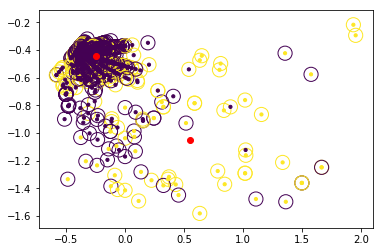

In [22]:
orig = plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, s=200)
orig.set_facecolor('None') # Set color to None
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=10, c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], c='red' );

#### Interpreting the results

We can see clearly that there are two distinct groups with some overlapping.The circles are to display survival based on y(target) while the dots are the kmeans clusters.

There are few outliers as well. The centroid of purple cluster is deeply rooted within the cluster. high cluster density signifies more datapoints near that centroid. This coluld possibly indicated the people who died. The other group with yellow colors with yellow dot inside possibly indicating the survived people.

The algorithm is not clearly specifying the clusters thus we can see the mismatch in the circle and the dot colors.

## 3. Implementing a search for best number of clusters using silhouette score

### Pipeline 

We are using pipeline so that we can iterate over multiple number of clusters. This will allow code reusability.

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
X_complete = tc.drop(['survived'], axis=1)

In [25]:
pipe = Pipeline([('scale', pp.StandardScaler()),('cluster', KMeans())])

In [26]:
pipe = Pipeline([('cluster', KMeans())])

#### Setting the parameters to 2,3,4,5,6 clusters

In [27]:
cluster__n_clusters = [2,3,4,5,6]

In [28]:
score = pd.DataFrame(columns=['clusters', 'silhouette_score', 'labels'])
for n_cluster in cluster__n_clusters:
    pipe = pipe.set_params(cluster__n_clusters = n_cluster)
    labels = pipe.fit_predict(X_complete)
    silhouette_avg = silhouette_score(X_complete, labels)
    score = score.append({'clusters':n_cluster, 'silhouette_score': silhouette_avg, 'labels': labels}, ignore_index=True)

In [29]:
score=score.sort_values(by='silhouette_score')
score

,clusters,silhouette_score,labels
3,5,0.518620,"[2, 0, 0, 2, 2, 1, 4, 1, 4, 4, 1, 3, 3, 2, 4, ..."
2,4,0.519663,"[3, 1, 1, 3, 3, 2, 0, 2, 0, 0, 2, 1, 3, 3, 0, ..."
4,6,0.522801,"[0, 2, 2, 0, 0, 1, 5, 3, 1, 5, 1, 4, 0, 0, 5, ..."
1,3,0.546449,"[0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, ..."
0,2,0.579319,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."


We can see silhouette score against each cluster. Out of these, the cluster with size 2, have the highest silhouette score

#### Interpreting the best results

As we have seen the silhouette score and found the cluster with size 2 has the highest silhouette score compare to the other cluster, therefore we can say that data is more classified when the number of cluster is 2 compare to other number of clusters. 

However, the cluster with 2 size, have silhouette score around .58, Therefore there is a lot of overlapping in the plot.
The last plot is showing the same.

#### Trying to find names for the clusters

Based on the above silhouette score table and the nature of the data we can interpret that the cluster names are as follows:

| Cluster Size| Cluster Name | Details |
|-------------|--------------|---------|
|`2`| sex or child|The label values in score table are only 0 or 1, thus it can be sex(M,F) or child(Child,Not Child)|
|`3`| pclass|The label values in score table are 0,1 and 2, thus it can be class1, class 2 and class 3|
|`4`| sibsp|High probability that the data is showing siblings and spouse within each class|
|`5`| parch|High probability that the data is showing parents and child within each class|
|`6`| family_size|High probability that the data is showing family size within each class|